# Purpose

### 2021-11-15
In this notebook I'll select the clusters for the One Feed experiment for **AUSTRALIA-relevant** subreddits.


**NOTE | 2021-11-11**<br>
The labels table should already be in BigQuery with standardized names, so read it from there rather than from GCS.

**Update 2021-11-11**<br>
Instead of saving this colab output to intermediary csv files, use `gspread` to write table outputs directly to google sheets.

# Imports & notebook setup

In [1]:
%load_ext google.colab.data_table
%load_ext autoreload
%autoreload 2

In [2]:
# colab auth for BigQuery
from google.colab import auth, files
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
# Attach google drive & import my python utility functions
# new way:
#. MANUALLY CLICK ON "Mount Drive"
# the catch is that now it'll be a different path:
g_drive_old = '/content/gdrive'
g_drive_new = '/content/drive'

# old way:
try:
    from google.colab import drive
    drive.mount(g_drive_old, force_remount=False)
    drive_root = g_drive_old
except Exception as e:
    drive_root = g_drive_new
    print(e)

import sys
l_paths_to_append = [
    f'{drive_root}/MyDrive/Colab Notebooks',

    # need to append the path to subclu so that colab can import things properly
    f'{drive_root}/MyDrive/Colab Notebooks/subreddit_clustering_i18n'
]
for path_ in l_paths_to_append:
    if path_ in sys.path:
        sys.path.remove(path_)
    print(f"Appending: {path_}")
    sys.path.append(path_)

Mounted at /content/gdrive
Appending: /content/gdrive/MyDrive/Colab Notebooks
Appending: /content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n


In [4]:
## install subclu & libraries needed to read parquet files from GCS
install_path = f"{drive_root}/MyDrive/Colab Notebooks/subreddit_clustering_i18n/"

!pip install -e $"$install_path" --quiet

     |████████████████████████████████| 10.1 MB 5.2 MB/s 
     |████████████████████████████████| 14.2 MB 195 kB/s 
     |████████████████████████████████| 965 kB 49.6 MB/s 
     |████████████████████████████████| 144 kB 50.6 MB/s 
     |████████████████████████████████| 285 kB 62.5 MB/s 
     |████████████████████████████████| 13.2 MB 155 kB/s 
     |████████████████████████████████| 79.9 MB 27 kB/s 
     |████████████████████████████████| 132 kB 54.0 MB/s 
     |████████████████████████████████| 715 kB 48.1 MB/s 
     |████████████████████████████████| 74 kB 3.8 MB/s 
     |████████████████████████████████| 112 kB 74.2 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 1.1 MB 63.7 MB/s 
     |████████████████████████████████| 180 kB 51.8 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 146 kB 56.1 MB/s 
     |████████████████████████████████| 596 kB 38.6 MB/s 
     |███████████████

In [5]:
# Install needed to load data from GCS, for some reason not included in subclu?
!pip install gcsfs --quiet

     |████████████████████████████████| 1.1 MB 7.9 MB/s 
     |████████████████████████████████| 160 kB 70.7 MB/s 
     |████████████████████████████████| 271 kB 83.4 MB/s 
     |████████████████████████████████| 192 kB 78.9 MB/s 


In [6]:
# Need to get latest version of gspread to read & write to google sheets
!pip install --upgrade gspread --quiet

In [7]:
# auth for google sheets
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [8]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


# os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-science-prod-218515'
os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

In [9]:
# subclu imports

# For reloading, need to force-delete some imported items
try:
    del LoadPosts, LoadSubreddits
except Exception:
    pass

from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)


setup_logging()
print_lib_versions([gspread, pd, np])

python		v 3.7.12
===
gspread		v: 4.0.1
pandas		v: 1.1.5
numpy		v: 1.19.5


# Load subreddit metadata

This data is already in bigQuery so read it straight from there. We'll use it to filter out geo-relevant (German) subs.

Also add the latest ratings so that we can filter based on those.

## SQL query

Make sure to update these variables to pick only subs from target country
- `GEO_COUNTRY_NAME` -> `reddit-employee-datasets.david_bermejo.subclu_geo_subreddits_20210922`
- `GEO_RELEVANT_COUNTRY_NAME` -> `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_languages`

In [10]:
%%time

sql_geo_and_languages = f"""
-- select DE subreddits + get latest rating
DECLARE GEO_COUNTRY_NAME STRING DEFAULT "Australia";
DECLARE GEO_RELEVANT_COUNTRY_NAME STRING DEFAULT r"%Australia%";

SELECT 
    sl.subreddit_id
    , sl.subreddit_name
    , r.rating
    -- , r.subrating
    , r.version

    , slo.verdict
    , slo.quarantine

    , geo.country_name
    , geo.users_percent_in_country
    -- , sl.geo_relevant_countries
    , ambassador_subreddit
    , posts_for_modeling_count

    , primary_post_language
    , primary_post_language_percent
    , secondary_post_language
    , secondary_post_language_percent

    , geo_relevant_country_count
    , geo_relevant_country_codes
    , geo_relevant_subreddit

FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_languages` sl
LEFT JOIN (
    SELECT * FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
    # Look back 2 days because looking back 1-day could be an empty partition
    WHERE dt = (CURRENT_DATE() - 2)
) AS slo
    ON slo.subreddit_id = sl.subreddit_id
LEFT JOIN (
    SELECT * FROM `reddit-employee-datasets.david_bermejo.subclu_geo_subreddits_20210922`
    WHERE country_name = GEO_COUNTRY_NAME
) AS geo 
    ON sl.subreddit_id = geo.subreddit_id
LEFT JOIN (
    SELECT * FROM ds_v2_subreddit_tables.subreddit_ratings
    WHERE DATE(pt) = (CURRENT_DATE() - 2)
) AS r
    ON r.subreddit_id = sl.subreddit_id

    
WHERE 1=1
    -- AND r.version = 'v2'
    -- AND COALESCE(r.rating, '') IN ('pg', 'pg13', 'g')
    AND COALESCE(slo.verdict, '') != 'admin-removed'
    AND COALESCE(slo.quarantine, false) != true
    AND (
        sl.geo_relevant_countries LIKE GEO_RELEVANT_COUNTRY_NAME
        -- OR sl.ambassador_subreddit = True
    )

ORDER BY users_percent_in_country ASC -- subreddit_name, ambassador_subreddit
;
"""

client = bigquery.Client()
df_geo_and_lang = client.query(sql_geo_and_languages).to_dataframe()
print(df_geo_and_lang.shape)

(78, 17)
CPU times: user 90.4 ms, sys: 8.63 ms, total: 99.1 ms
Wall time: 9.6 s


## Check data with geo + language information

In [11]:
df_geo_and_lang.head()

,subreddit_id,subreddit_name,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
0,t5_2th5n,paramedics,pg13,v2,None,False,Australia,0.160752,False,156.0,English,0.993590,None,NaN,2.0,"AU, CA",True
1,t5_2sz2k,skulduggerypleasant,pg,v1,None,False,Australia,0.168433,False,403.0,English,0.962779,None,NaN,2.0,"AU, GB",True
2,t5_ozai2,ucat,pg,v3,None,False,Australia,0.172504,False,720.0,English,0.993056,None,NaN,2.0,"AU, GB",True
3,t5_ae99p,verasity,pg13,v2,None,False,Australia,0.173486,False,349.0,English,0.977077,None,NaN,1.0,AU,True
4,t5_2x1dq,lifx,g,v1,None,False,Australia,0.184265,False,156.0,English,0.980769,Indonesian,0.012821,1.0,AU,True


In [12]:
df_geo_and_lang.tail()

,subreddit_id,subreddit_name,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,posts_for_modeling_count,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit
73,t5_2fyaa6,coronavirusaustralia,pg13,v3,None,False,Australia,0.965548,False,337.0,English,0.970326,Spanish,0.011869,1.0,AU,True
74,t5_2wtac,ausproperty,pg,v1,None,False,Australia,0.968282,False,250.0,English,0.996000,None,NaN,1.0,AU,True
75,t5_2s98u,geelong,pg13,v2,None,False,Australia,0.970873,False,159.0,English,0.962264,German,0.012579,1.0,AU,True
76,t5_2s47u,nbn,g,v1,None,False,Australia,0.978459,False,145.0,English,0.979310,None,NaN,1.0,AU,True
77,t5_2rgp5,centrelink,g,v1,None,False,Australia,0.978584,False,597.0,English,0.998325,None,NaN,1.0,AU,True


# Load model labels

~Ideally we could just pull the configuration data from github~

The clusters now live in a big Query table and have standardized names, so pull the data from there.

## Pull data from BigQuery


In [13]:
%%time

sql_labels = f"""
-- select subreddit clusters from bigQuery

SELECT
    subreddit_id
    , subreddit_name
    , sc.* EXCEPT(subreddit_id, subreddit_name)
FROM `reddit-employee-datasets.david_bermejo.subclu_v0040_subreddit_clusters_c_a` sc
;
"""

client = bigquery.Client()
df_labels = client.query(sql_labels).to_dataframe()
print(df_labels.shape)

(19053, 17)
CPU times: user 1 s, sys: 77.7 ms, total: 1.08 s
Wall time: 3.57 s


In [14]:
df_labels.head()

,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,table_creation_date,mlflow_run_uuid
0,t5_386fy,xtrill,41,32,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
1,t5_2roop,hardtechno,49,18,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
2,t5_2qziu,rappers,76,386,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
3,t5_2vrp8,musicaargentina,84,26,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
4,t5_2smd3,musik,85,23,None,1,1,1,1,1,Music,Music,Music,Music,Music,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71


In [15]:
counts_describe(df_labels)

20:34:36 | INFO | "NumExpr defaulting to 2 threads."


,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"19,053","19,053",100.00%,0,0.00%
subreddit_name,object,"19,053","19,053",100.00%,0,0.00%
model_distance_order,int64,"19,053","19,053",100.00%,0,0.00%
posts_for_modeling_count,int64,"19,053","1,175",6.17%,0,0.00%
primary_topic_0921,object,"15,929",51,0.32%,"3,124",16.40%
k052_label,int64,"19,053",52,0.27%,0,0.00%
k100_label,int64,"19,053",100,0.52%,0,0.00%
k248_label,int64,"19,053",248,1.30%,0,0.00%
k351_label,int64,"19,053",351,1.84%,0,0.00%
k405_label,int64,"19,053",405,2.13%,0,0.00%


### Overview of cluster distribution at k=405

In [16]:
df_counts_405k = value_counts_and_pcts(
    df_labels['k405_label'],
    top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
)
df_counts_405k.shape

(405, 4)

In [17]:
style_df_numeric(df_counts_405k.head(14), l_bar_simple=['count', 'percent'])

,k405_label,count,percent,cumulative_percent
0,371,211,1.11%,1.11%
1,16,195,1.02%,2.13%
2,124,160,0.84%,2.97%
3,5,155,0.81%,3.78%
4,385,154,0.81%,4.59%
5,93,151,0.79%,5.38%
6,74,146,0.77%,6.15%
7,77,146,0.77%,6.92%
8,1,144,0.76%,7.67%
9,135,144,0.76%,8.43%


In [18]:
style_df_numeric(df_counts_405k.tail(10), l_bar_simple=['count', 'percent'])

,k405_label,count,percent,cumulative_percent
395,269,12,0.06%,99.53%
396,324,12,0.06%,99.60%
397,268,12,0.06%,99.66%
398,358,12,0.06%,99.72%
399,206,11,0.06%,99.78%
400,186,11,0.06%,99.84%
401,351,9,0.05%,99.88%
402,130,8,0.04%,99.93%
403,194,8,0.04%,99.97%
404,20,6,0.03%,100.00%


In [19]:
print(19000 / 500)
19000 / 900

38.0


21.11111111111111

In [20]:
df_counts_405k['count'].describe(percentiles=[.05, .1, .2, .25, .5, .75, .8, .9, .95])

count    405.000000
mean      47.044444
std       32.100137
min        6.000000
5%        13.000000
10%       17.000000
20%       23.000000
25%       25.000000
50%       38.000000
75%       58.000000
80%       68.000000
90%       85.000000
95%      115.000000
max      211.000000
Name: count, dtype: float64

In [21]:
# ax = sns.displot(df_lbl_counts52['count'], label='52', kind='kde')
# ax = sns.displot(df_lbl_counts100['count'], label='100', kind='kde')

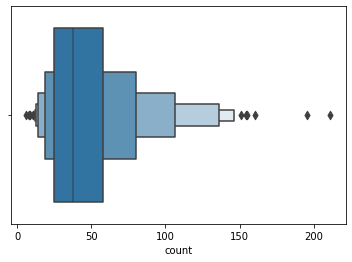

In [22]:
sns.boxenplot(x=df_counts_405k['count'], label='52')
plt.show()

# Keep only labels for target country


In [23]:
l_ix_subs = ['subreddit_name', 'subreddit_id']

df_labels_target = (
    df_labels
    .merge(
        df_geo_and_lang.drop(['posts_for_modeling_count'], axis=1),
        how='right',
        on=l_ix_subs,
    )
    .copy()
    .sort_values(by=['model_distance_order'], ascending=True)
)

# move some columns to the end of the file
l_cols_to_end = ['table_creation_date', 'mlflow_run_uuid']

df_labels_target = df_labels_target[
    df_labels_target.drop(l_cols_to_end, axis=1).columns.to_list() +
    l_cols_to_end
]
print(df_labels_target.shape)

(78, 31)


### Drop subs with too few posts

In the modeling process I drop subreddits with too few posts. We don't have recommendations for them, so let's drop them.

It would also not be a great experience to recommend dead subs.

In [24]:
df_labels_target['model_distance_order'].isnull().sum()

0

In [25]:
df_labels_target = df_labels_target[
    ~df_labels_target['model_distance_order'].isnull()
].copy()
df_labels_target['model_distance_order'] = df_labels_target['model_distance_order'].astype(int)

l_cols_labels = [c for c in df_labels_target.columns if c.endswith('_label')]
df_labels_target[l_cols_labels] = df_labels_target[l_cols_labels].astype(int)

df_labels_target.shape

(78, 31)

In [26]:
style_df_numeric(
    df_labels_target.head(10),
    # rename_cols_for_display=True,
    pct_labels=['_percent_in_country', '_percent'],
    int_labels=None,
    pct_cols=['users_percent_in_country'],
    l_bar_simple=[c for c in df_labels_target.columns if '_label' in c]
)

,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid
11,t5_uj5o4,thekidlaroi,535,382,Music,1,2,4,5,5,Music,Music,Music,Music,Music,pg,v3,None,False,Australia,0,False,English,90.84%,German,1.83%,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
5,t5_2yjom,wentworthtv,"1,304",473,Television,3,5,11,16,16,Television,Television,Television,Television,Television,r,v1,None,False,Australia,0,False,English,94.50%,German,2.11%,2,"AU, GB",True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
9,t5_2srvz,animalkingdom,"1,335",279,Television,3,5,11,16,16,Television,Television,Television,Television,Television,r,v2,None,False,Australia,0,False,English,97.13%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
17,t5_2odtqg,sarahsdayunfiltered,"1,493",119,Fitness and Nutrition,3,5,12,17,17,Television,Television,Television,Television,Television,None,None,None,False,Australia,0,False,English,94.96%,French,0.84%,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
20,t5_3avlw,survivorau,"1,574",582,Television,3,5,13,18,18,Television,Television,Television,Television,Television,pg13,v2,None,False,Australia,1,False,English,97.59%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
33,t5_2qq98,theblock,"1,580",169,Television,3,5,13,18,18,Television,Television,Television,Television,Television,g,v1,None,False,Australia,1,False,English,99.41%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
1,t5_2sz2k,skulduggerypleasant,"1,738",403,"Reading, Writing, and Literature",4,6,15,21,22,"Reading, Writing, and Literature","Reading, Writing, and Literature","Reading, Writing, and Literature","Reading, Writing, and Literature","Reading, Writing, and Literature",pg,v1,None,False,Australia,0,False,English,96.28%,None,-,2,"AU, GB",True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
15,t5_32d3t,auntydonna,"3,960",210,Funny/Humor,11,16,36,51,55,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,r,v2,None,False,Australia,0,False,English,92.86%,Danish,0.95%,2,"AU, GB",True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
54,t5_321dg,friendlyjordies,"4,018",248,Podcasts and Streamers,11,16,36,51,55,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,pg13,v3,None,False,Australia,1,False,English,89.52%,German,3.23%,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
53,t5_2wxtr,ausmemes,"4,019",691,Internet Culture and Memes,11,16,36,51,55,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,pg13,v2,None,False,Australia,1,False,English,81.91%,German,1.59%,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71


In [27]:
style_df_numeric(
    df_labels_target.tail(10),
    # rename_cols_for_display=True,
    l_bar_simple=[c for c in df_labels_target.columns if '_label' in c]
)

,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid
0,t5_2th5n,paramedics,"18,289",156,Learning and Education,50,94,236,336,388,Learning and Education,Learning and Education,Careers,Careers,Careers,pg13,v2,None,False,Australia,0,False,English,99.36%,None,-,2,"AU, CA",True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
8,t5_2rplw,physiotherapy,"18,295",149,Medical and Mental Health,50,94,236,336,388,Learning and Education,Learning and Education,Careers,Careers,Careers,pg13,v2,None,False,Australia,0,False,English,100.00%,None,-,2,"AU, CA",True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
68,t5_3phq9,australianteachers,"18,335",399,Careers,50,94,237,337,389,Learning and Education,Learning and Education,Learning and Education,Learning and Education,Learning and Education,pg,v3,None,False,Australia,1,False,English,100.00%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
77,t5_2rgp5,centrelink,"18,778",597,None,52,97,243,345,398,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance",g,v1,None,False,Australia,1,False,English,99.83%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
74,t5_2wtac,ausproperty,"18,838",250,"Business, Economics, and Finance",52,98,244,347,400,"Business, Economics, and Finance",Home and Garden,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance",pg,v1,None,False,Australia,1,False,English,99.60%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
66,t5_2uo3q,ausfinance,"18,936","1,200","Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance",g,v1,None,False,Australia,1,False,English,99.83%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
60,t5_39zkf,fiaustralia,"18,937",527,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance",g,v1,None,False,Australia,1,False,English,98.86%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
51,t5_2xmxy,australianmilitary,"18,996",130,Military,52,100,247,350,403,"Business, Economics, and Finance",Law,Military,Military,Military,r,v1,None,False,Australia,1,False,English,96.92%,Indonesian,1.54%,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
28,t5_2zqu2,auslegal,"19,021",718,Law,52,100,248,351,404,"Business, Economics, and Finance",Law,Law,Law,Law,r,v2,None,False,Australia,1,False,English,99.72%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
56,t5_2stjv,auslaw,"19,029",528,Law,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law,pg,v1,None,False,Australia,1,False,English,98.30%,None,-,1,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71


# Create new clustering logic to resize clusters

We want to balance two things:
- prevent orphan subreddits
- prevent clusters that are too large to be meaningful

In order to do this at a country level, we'll be better off starting with smallest cluster size and roll up until we have at least N subreddits in one cluster.

For now, let's set the threshold at 4.

In [38]:
N_MIN_SUBREDDITS_IN_CLUSTER = 5

# Create new cols that have zero-padding so we can concat and sort them
l_cols_labels_new = [f"{c}_nested" for c in l_cols_labels]

df_labels_target[l_cols_labels_new] = df_labels_target[l_cols_labels].apply(lambda x: x.map("{:03.0f}".format))

for i in range(len(l_cols_labels_new)):
    if i == 0:
        df_labels_target[l_cols_labels_new[-1]] = (
            df_labels_target[l_cols_labels_new[0]]
            .str.cat(
                df_labels_target[l_cols_labels_new[1:]],
                sep='-'
            )
        )
    else:
        # print(l_cols_labels_new[-i - 1])
        # print(l_cols_labels_new[:-i])
        df_labels_target[l_cols_labels_new[-i - 1]] = (
            df_labels_target[l_cols_labels_new[0]]
            .str.cat(
                df_labels_target[l_cols_labels_new[1:-i]],
                sep='-'
            )
        )

In [39]:
col_new_cluster_val = 'cluster_label'
col_new_cluster_name = 'cluster_label_k'
col_new_cluster_prim_topic = 'cluster_majority_primary_topic'

df_labels_target[col_new_cluster_val] = df_labels_target[l_cols_labels_new[-1]]
df_labels_target[col_new_cluster_name] = l_cols_labels_new[-1].replace('_nested', '')
df_labels_target[col_new_cluster_prim_topic] = df_labels_target[
    l_cols_labels_new[-1].replace('_label_nested', '_majority_primary_topic')
]

for c_ in sorted(l_cols_labels_new[:-1], reverse=True):
    c_name_new = c_.replace('_nested', '')
    col_update_prim_topic = c_.replace('_label_nested', '_majority_primary_topic')

    # find which current clusters are below threshold
    df_vc = df_labels_target[col_new_cluster_val].value_counts()
    dv_vc_below_threshold = df_vc[df_vc <= N_MIN_SUBREDDITS_IN_CLUSTER]
    display(dv_vc_below_threshold.shape)

    # Replace cluster labels & names for current clusters that have too few subs in a cluster
    mask_subs_to_reassign = df_labels_target[col_new_cluster_val].isin(dv_vc_below_threshold.index)
    df_labels_target.loc[
        mask_subs_to_reassign,
        col_new_cluster_val
    ] = df_labels_target[mask_subs_to_reassign][c_]

    df_labels_target.loc[
        mask_subs_to_reassign,
        col_new_cluster_name
    ] = c_name_new

    df_labels_target.loc[
        mask_subs_to_reassign,
        col_new_cluster_prim_topic
    ] = df_labels_target[mask_subs_to_reassign][col_update_prim_topic]

# reorder columns so it's easier to see new target col & drop repeated "nested" cols
df_labels_target = (
    df_labels_target
    [reorder_array(
        [
            'subreddit_id',
            'subreddit_name',
            'model_distance_order',
            'posts_for_modeling_count',
            'primary_topic_0921',
            'cluster_label',
            'cluster_label_k',
            'cluster_majority_primary_topic',
        ],
        df_labels_target.columns
    )]
)

(43,)

(42,)

(39,)

(27,)

In [40]:
df_labels_target.head()

,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,cluster_label,cluster_label_k,cluster_majority_primary_topic,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid,k052_label_nested,k100_label_nested,k248_label_nested,k351_label_nested,k405_label_nested
11,t5_uj5o4,thekidlaroi,535,382,Music,001,k052_label,Music,1,2,4,5,5,Music,Music,Music,Music,Music,pg,v3,None,False,Australia,0.215195,False,English,0.908377,German,0.018325,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,001,001-002,001-002-004,001-002-004-005,001-002-004-005-005
5,t5_2yjom,wentworthtv,1304,473,Television,003,k052_label,Television,3,5,11,16,16,Television,Television,Television,Television,Television,r,v1,None,False,Australia,0.198398,False,English,0.945032,German,0.021142,2.0,"AU, GB",True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,003,003-005,003-005-011,003-005-011-016,003-005-011-016-016
9,t5_2srvz,animalkingdom,1335,279,Television,003,k052_label,Television,3,5,11,16,16,Television,Television,Television,Television,Television,r,v2,None,False,Australia,0.212683,False,English,0.971326,None,NaN,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,003,003-005,003-005-011,003-005-011-016,003-005-011-016-016
17,t5_2odtqg,sarahsdayunfiltered,1493,119,Fitness and Nutrition,003,k052_label,Television,3,5,12,17,17,Television,Television,Television,Television,Television,None,None,None,False,Australia,0.442234,False,English,0.949580,French,0.008403,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,003,003-005,003-005-012,003-005-012-017,003-005-012-017-017
20,t5_3avlw,survivorau,1574,582,Television,003,k052_label,Television,3,5,13,18,18,Television,Television,Television,Television,Television,pg13,v2,None,False,Australia,0.612770,False,English,0.975945,None,NaN,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,003,003-005,003-005-013,003-005-013-018,003-005-013-018-018


## cases to over-ride manually
Example: 

 - https://www.reddit.com/r/Humour_en_tout_genre/

This sub gets orphaned because it's not in the same niche as: 
`011-017-039-054`



In [41]:
# TODO

In [42]:
# d_manual_override = {
#     '011-017-039-054': {
#         'label': ,
#         'label_k': ,
#         'value': ,
#     }
# }

## Compare clusters at k=52 & at custom cluster depth

We want to avoid having clusters of one subreddit b/c that means we have nothing to recommend.

Looks like even at 52 there are some subreddits that are orphans in France... so maybe we can't use them for FPR in France to France, but maybe we can use them for onboarding or something else?

In [43]:
df_lbl_counts52 = value_counts_and_pcts(
    df_labels_target['k052_label'], top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
).sort_values(by=['count'], ascending=False)
df_lbl_counts52.shape

(26, 4)

In [44]:
df_lbl_counts_custom = value_counts_and_pcts(
    df_labels_target[col_new_cluster_val], top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
).sort_values(by=['count'], ascending=False)
df_lbl_counts_custom.shape

(26, 4)

In [45]:
style_df_numeric(df_lbl_counts52.head(10), l_bar_simple=['count', 'percent'])

,k052_label,count,percent,cumulative_percent
0,48,11,14.10%,14.10%
1,50,10,12.82%,26.92%
2,52,7,8.97%,35.90%
3,23,6,7.69%,43.59%
4,3,5,6.41%,50.00%
5,11,5,6.41%,56.41%
6,42,4,5.13%,61.54%
7,21,4,5.13%,66.67%
10,20,3,3.85%,78.21%
9,39,3,3.85%,74.36%


In [46]:
style_df_numeric(df_lbl_counts_custom.head(10), l_bar_simple=['count', 'percent'])

,cluster_label,count,percent,cumulative_percent
0,048-090-226-323-372,11,14.10%,14.10%
1,050-094,10,12.82%,26.92%
2,052,7,8.97%,35.90%
3,023-041-108,6,7.69%,43.59%
4,003,5,6.41%,50.00%
5,011,5,6.41%,56.41%
6,042,4,5.13%,61.54%
7,021,4,5.13%,66.67%
10,024,3,3.85%,78.21%
9,039,3,3.85%,74.36%


In [47]:
style_df_numeric(df_lbl_counts_custom.tail(15), l_bar_simple=['count', 'percent'])

,cluster_label,count,percent,cumulative_percent
11,040,2,2.56%,80.77%
12,019,2,2.56%,83.33%
19,001,1,1.28%,92.31%
24,032,1,1.28%,98.72%
23,033,1,1.28%,97.44%
22,041,1,1.28%,96.15%
21,047,1,1.28%,94.87%
20,037,1,1.28%,93.59%
13,026,1,1.28%,84.62%
18,018,1,1.28%,91.03%


In [48]:
df_lbl_counts52['count'].describe()

count    26.000000
mean      3.000000
std       2.842534
min       1.000000
25%       1.000000
50%       1.500000
75%       4.000000
max      11.000000
Name: count, dtype: float64

In [49]:
df_lbl_counts_custom['count'].describe()

count    26.000000
mean      3.000000
std       2.842534
min       1.000000
25%       1.000000
50%       1.500000
75%       4.000000
max      11.000000
Name: count, dtype: float64

In [50]:
# ax = sns.displot(df_lbl_counts52['count'], label='52', kind='kde')
# ax = sns.displot(df_lbl_counts100['count'], label='100', kind='kde')

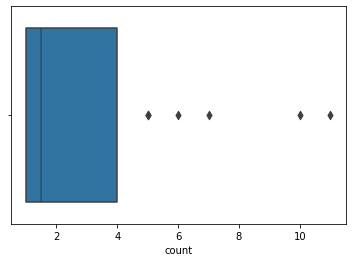

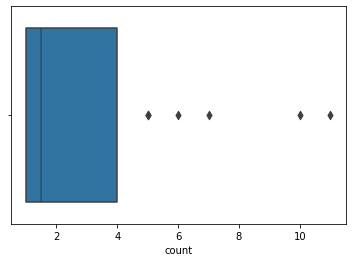

In [51]:
sns.boxenplot(x=df_lbl_counts52['count'], label='52')
plt.show()
sns.boxenplot(x=df_lbl_counts_custom['count'], label='custom')

In [52]:
l_orphan_cluster_ids = df_lbl_counts52[df_lbl_counts52['count'] <= 1]['k052_label'].values
print(len(l_orphan_cluster_ids))

df_labels_target[df_labels_target['k052_label'].isin(l_orphan_cluster_ids)]

13


,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,cluster_label,cluster_label_k,cluster_majority_primary_topic,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid,k052_label_nested,k100_label_nested,k248_label_nested,k351_label_nested,k405_label_nested
11,t5_uj5o4,thekidlaroi,535,382,Music,001,k052_label,Music,1,2,4,5,5,Music,Music,Music,Music,Music,pg,v3,None,False,Australia,0.215195,False,English,0.908377,German,0.018325,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,001,001-002,001-002-004,001-002-004-005,001-002-004-005-005
1,t5_2sz2k,skulduggerypleasant,1738,403,"Reading, Writing, and Literature",004,k052_label,"Reading, Writing, and Literature",4,6,15,21,22,"Reading, Writing, and Literature","Reading, Writing, and Literature","Reading, Writing, and Literature","Reading, Writing, and Literature","Reading, Writing, and Literature",pg,v1,None,False,Australia,0.168433,False,English,0.962779,None,NaN,2.0,"AU, GB",True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,004,004-006,004-006-015,004-006-015-021,004-006-015-021-022
14,t5_4izfkp,leaksandrumors,7347,601,Gaming,018,k052_label,Gaming,18,30,72,102,116,Gaming,Gaming,Gaming,Gaming,Gaming,None,None,None,False,Australia,0.268578,False,English,0.960067,German,0.008319,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,018,018-030,018-030-072,018-030-072-102,018-030-072-102-116
37,t5_340dk,askanaustralian,10790,375,Learning and Education,026,k052_label,History,26,46,121,170,198,History,"Culture, Race, and Ethnicity",Place,Place,Place,pg,v1,None,False,Australia,0.809293,False,English,0.994667,None,NaN,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,026,026-046,026-046-121,026-046-121-170,026-046-121-170-198
4,t5_2x1dq,lifx,11474,156,Technology,029,k052_label,Technology,29,51,133,186,217,Technology,Technology,Technology,Technology,Technology,g,v1,None,False,Australia,0.184265,False,English,0.980769,Indonesian,0.012821,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,029,029-051,029-051-133,029-051-133-186,029-051-133-186-217
76,t5_2s47u,nbn,11906,145,Technology,030,k052_label,Technology,30,54,140,198,233,Technology,Technology,Technology,Technology,Technology,g,v1,None,False,Australia,0.978459,False,English,0.979310,None,NaN,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,030,030-054,030-054-140,030-054-140-198,030-054-140-198-233
24,t5_2tevl,bapcsalesaustralia,12273,440,Marketplace and Deals,032,k052_label,Technology,32,56,145,206,242,Technology,Technology,Technology,Technology,Technology,g,v1,None,False,Australia,0.720490,False,English,0.997727,None,NaN,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,032,032-056,032-056-145,032-056-145-206,032-056-145-206-242
16,t5_2u8k1,jimny,12805,160,Cars and Motor Vehicles,033,k052_label,Cars and Motor Vehicles,33,59,151,214,250,Cars and Motor Vehicles,Cars and Motor Vehicles,Cars and Motor Vehicles,Cars and Motor Vehicles,Cars and Motor Vehicles,pg,v3,None,False,Australia,0.301357,False,English,0.925000,Spanish,0.012500,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,033,033-059,033-059-151,033-059-151-214,033-059-151-214-250
19,t5_3jrrr,ozbargainnew,13786,1200,Marketplace and Deals,037,k052_label,Marketplace and Deals,37,65,169,239,279,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,pg,v3,None,False,Australia,0.592969,False,English,0.942500,Danish,0.013333,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,037,037-065,037-065-169,037-

In [53]:
l_orphan_cluster_ids2 = df_lbl_counts_custom[df_lbl_counts_custom['count'] <= 1][col_new_cluster_val].values
print(len(l_orphan_cluster_ids2))

df_labels_target[df_labels_target[col_new_cluster_val].isin(l_orphan_cluster_ids2)]

13


,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,cluster_label,cluster_label_k,cluster_majority_primary_topic,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid,k052_label_nested,k100_label_nested,k248_label_nested,k351_label_nested,k405_label_nested
11,t5_uj5o4,thekidlaroi,535,382,Music,001,k052_label,Music,1,2,4,5,5,Music,Music,Music,Music,Music,pg,v3,None,False,Australia,0.215195,False,English,0.908377,German,0.018325,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,001,001-002,001-002-004,001-002-004-005,001-002-004-005-005
1,t5_2sz2k,skulduggerypleasant,1738,403,"Reading, Writing, and Literature",004,k052_label,"Reading, Writing, and Literature",4,6,15,21,22,"Reading, Writing, and Literature","Reading, Writing, and Literature","Reading, Writing, and Literature","Reading, Writing, and Literature","Reading, Writing, and Literature",pg,v1,None,False,Australia,0.168433,False,English,0.962779,None,NaN,2.0,"AU, GB",True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,004,004-006,004-006-015,004-006-015-021,004-006-015-021-022
14,t5_4izfkp,leaksandrumors,7347,601,Gaming,018,k052_label,Gaming,18,30,72,102,116,Gaming,Gaming,Gaming,Gaming,Gaming,None,None,None,False,Australia,0.268578,False,English,0.960067,German,0.008319,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,018,018-030,018-030-072,018-030-072-102,018-030-072-102-116
37,t5_340dk,askanaustralian,10790,375,Learning and Education,026,k052_label,History,26,46,121,170,198,History,"Culture, Race, and Ethnicity",Place,Place,Place,pg,v1,None,False,Australia,0.809293,False,English,0.994667,None,NaN,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,026,026-046,026-046-121,026-046-121-170,026-046-121-170-198
4,t5_2x1dq,lifx,11474,156,Technology,029,k052_label,Technology,29,51,133,186,217,Technology,Technology,Technology,Technology,Technology,g,v1,None,False,Australia,0.184265,False,English,0.980769,Indonesian,0.012821,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,029,029-051,029-051-133,029-051-133-186,029-051-133-186-217
76,t5_2s47u,nbn,11906,145,Technology,030,k052_label,Technology,30,54,140,198,233,Technology,Technology,Technology,Technology,Technology,g,v1,None,False,Australia,0.978459,False,English,0.979310,None,NaN,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,030,030-054,030-054-140,030-054-140-198,030-054-140-198-233
24,t5_2tevl,bapcsalesaustralia,12273,440,Marketplace and Deals,032,k052_label,Technology,32,56,145,206,242,Technology,Technology,Technology,Technology,Technology,g,v1,None,False,Australia,0.720490,False,English,0.997727,None,NaN,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,032,032-056,032-056-145,032-056-145-206,032-056-145-206-242
16,t5_2u8k1,jimny,12805,160,Cars and Motor Vehicles,033,k052_label,Cars and Motor Vehicles,33,59,151,214,250,Cars and Motor Vehicles,Cars and Motor Vehicles,Cars and Motor Vehicles,Cars and Motor Vehicles,Cars and Motor Vehicles,pg,v3,None,False,Australia,0.301357,False,English,0.925000,Spanish,0.012500,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,033,033-059,033-059-151,033-059-151-214,033-059-151-214-250
19,t5_3jrrr,ozbargainnew,13786,1200,Marketplace and Deals,037,k052_label,Marketplace and Deals,37,65,169,239,279,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,pg,v3,None,False,Australia,0.592969,False,English,0.942500,Danish,0.013333,1.0,AU,True,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71,037,037-065,037-065-169,037-

# Export raw data: 1 row=1 subreddit

Make sure it's ordered by the col to sort subs similar to each other

In [ ]:
gspread.__version__

'4.0.1'

In [54]:
# %%time

GSHEET_NAME = 'i18n Australia subreddits and clusters - model v0.4.0'
GSHEET_KEY = None
SH_RAW_SUB_OUTPUT = 'raw_data_per_subreddit'
SH_RAW_CLUSTER_LIST_52 = 'raw_cluster_list_names_52'
SH_RAW_CLUSTER_LIST_CUSTOM = 'raw_cluster_list_names_custom'
SH_RAW_CLUSTERS_CUSTOM = 'raw_clusters_custom-subreddit_name'

if GSHEET_KEY is not None:
    sh = gc.open_by_key(GSHEET_KEY)
else:
    print(f"Creating google worksheet: {GSHEET_NAME} ...")
    sh = gc.create(GSHEET_NAME)

try:
    wsh_raw_sub_output = sh.worksheet(SH_RAW_SUB_OUTPUT)
except Exception as e:
    print(f"Creating tab/sheet: {SH_RAW_SUB_OUTPUT} ...")
    wsh_raw_sub_output  = sh.add_worksheet(
        title=SH_RAW_SUB_OUTPUT, 
        rows=len(df_labels_target) + 10, 
        cols=len(df_labels_target) + 1
    )

try:
    wsh_raw_list_custom = sh.worksheet(SH_RAW_CLUSTER_LIST_CUSTOM)
except Exception as e:
    print(f"Creating tab/sheet: {SH_RAW_CLUSTER_LIST_CUSTOM} ...")
    wsh_raw_list_custom = sh.add_worksheet(title=SH_RAW_CLUSTER_LIST_CUSTOM, rows="110", cols="20")

try:
    wsh_raw_clusters_custom = sh.worksheet(SH_RAW_CLUSTERS_CUSTOM)
except Exception as e:
    print(f"Creating tab/sheet: {SH_RAW_CLUSTERS_CUSTOM} ...")
    wsh_raw_clusters_custom = sh.add_worksheet(title=SH_RAW_CLUSTERS_CUSTOM, rows="110", cols="20")


# try:
#     wsh_raw_list_52 = sh.worksheet(SH_RAW_CLUSTER_LIST_52)
# except Exception as e:
#     print(f"Creating tab/sheet: {SH_RAW_CLUSTER_LIST_52} ...")
#     wsh_raw_list_52 = sh.add_worksheet(title=SH_RAW_CLUSTER_LIST_52, rows="60", cols="20")

Creating google worksheet: i18n Australia subreddits and clusters - model v0.4.0 ...
Creating tab/sheet: raw_data_per_subreddit ...
Creating tab/sheet: raw_cluster_list_names_custom ...
Creating tab/sheet: raw_clusters_custom-subreddit_name ...


### Note that we have to use `fillna('')`

Otherwise, we'll get errors because the gspread library doesn't know how to handle `pd.NaN` or `np.Nan` (nulls).

In [55]:
%%time

wsh_raw_sub_output.update(
    [df_labels_target.drop(l_cols_labels_new, axis=1).columns.values.tolist()] + 
    df_labels_target.drop(l_cols_labels_new, axis=1).fillna('').values.tolist()
)

CPU times: user 9.48 ms, sys: 525 µs, total: 10 ms
Wall time: 357 ms


{'spreadsheetId': '1kbsbQFxUyzBpPQbpx1oqhQg0TQpFtRoSCj8vR7mBAAk',
 'updatedCells': 2686,
 'updatedColumns': 34,
 'updatedRange': 'raw_data_per_subreddit!A1:AH79',
 'updatedRows': 79}

### We can read the data back to confirm it's as expected

In [56]:
# Here's how to get the records as a dataframe
pd.DataFrame(wsh_raw_sub_output.get_all_records())

,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,cluster_label,cluster_label_k,cluster_majority_primary_topic,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid
0,t5_uj5o4,thekidlaroi,535,382,Music,1,k052_label,Music,1,2,4,5,5,Music,Music,Music,Music,Music,pg,v3,,FALSE,Australia,0.215195,FALSE,English,0.908377,German,0.0183246,1,AU,TRUE,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
1,t5_2yjom,wentworthtv,1304,473,Television,3,k052_label,Television,3,5,11,16,16,Television,Television,Television,Television,Television,r,v1,,FALSE,Australia,0.198398,FALSE,English,0.945032,German,0.0211416,2,"AU, GB",TRUE,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
2,t5_2srvz,animalkingdom,1335,279,Television,3,k052_label,Television,3,5,11,16,16,Television,Television,Television,Television,Television,r,v2,,FALSE,Australia,0.212683,FALSE,English,0.971326,,,1,AU,TRUE,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
3,t5_2odtqg,sarahsdayunfiltered,1493,119,Fitness and Nutrition,3,k052_label,Television,3,5,12,17,17,Television,Television,Television,Television,Television,,,,FALSE,Australia,0.442234,FALSE,English,0.949580,French,0.00840336,1,AU,TRUE,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
4,t5_3avlw,survivorau,1574,582,Television,3,k052_label,Television,3,5,13,18,18,Television,Television,Television,Television,Television,pg13,v2,,FALSE,Australia,0.612770,FALSE,English,0.975945,,,1,AU,TRUE,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,t5_2uo3q,ausfinance,18936,1200,"Business, Economics, and Finance",52,k052_label,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance",g,v1,,FALSE,Australia,0.941713,FALSE,English,0.998333,,,1,AU,TRUE,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
74,t5_39zkf,fiaustralia,18937,527,"Business, Economics, and Finance",52,k052_label,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance",g,v1,,FALSE,Australia,0.934471,FALSE,English,0.988615,,,1,AU,TRUE,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
75,t5_2xmxy,australianmilitary,18996,130,Military,52,k052_label,"Business, Economics, and Finance",52,100,247,350,403,"Business, Economics, and Finance",Law,Military,Military,Military,r,v1,,FALSE,Australia,0.912445,FALSE,English,0.969231,Indonesian,0.0153846,1,AU,TRUE,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71
76,t5_2zqu2,auslegal,19021,718,Law,52,k052_label,"Business, Economics, and Finance",52,100,248,351,404,"Business, Economics, and Finance",Law,Law,Law,Law,r,v2,,FALSE,Australia,0.752499,FALSE,English,0.997214,,,1,AU,TRUE,2021-10-29,134cefe13ae34621a69fcc48c4d5fb71


# Reshape: flatten topics into 1 row = 1 cluster/topic

In [57]:
%%time
col_cluster_level = col_new_cluster_val
col_cluster_k = col_new_cluster_name
col_cluster_majority_topic = col_new_cluster_prim_topic

df_cluster_per_row_list = (
    df_labels_target
    .groupby([col_cluster_level, col_cluster_k, col_cluster_majority_topic])
    ['subreddit_name']
    .agg(
        [
            ('subreddit_count', 'count'),
            ('list_of_subs', list)
        ]
    )
    .reset_index()
)
print(df_cluster_per_row_list.shape)

# Convert the list of subs into a df & merge back with original sub (each sub should be in a new column)
df_cluster_per_row = (
    df_cluster_per_row_list
    .merge(
        pd.DataFrame(df_cluster_per_row_list['list_of_subs'].to_list()).fillna(''),
        how='left',
        left_index=True,
        right_index=True,
    )
    .drop(['list_of_subs'], axis=1)
)

# when convertion to JSON for gspread, it's better to conver the list into a string
# and to remove the brackets
df_cluster_per_row_list['list_of_subs'] = (
    df_cluster_per_row_list['list_of_subs']
    .astype(str)
    .str[1:-1]
    .str.replace("'", "")
)

print(df_cluster_per_row.shape)

(26, 5)
(26, 15)
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 15.7 ms


In [58]:
df_cluster_per_row_list.head(int(len(df_cluster_per_row_list) / 2) + 1)

,cluster_label,cluster_label_k,cluster_majority_primary_topic,subreddit_count,list_of_subs
0,001,k052_label,Music,1,thekidlaroi
1,003,k052_label,Television,5,"wentworthtv, animalkingdom, sarahsdayunfiltere..."
2,004,k052_label,"Reading, Writing, and Literature",1,skulduggerypleasant
3,011,k052_label,Podcasts and Streamers,5,"auntydonna, friendlyjordies, ausmemes, straya,..."
4,018,k052_label,Gaming,1,leaksandrumors
5,019,k052_label,Crypto,2,"bitcoinaus, verasity"
6,020,k052_label,"Business, Economics, and Finance",3,"asx, ausstocks, asx_bets"
7,021,k052_label,Sports,4,"aleague, superleague, afl, nrl"
8,023-041-108,k248_label,Politics,6,"newsfeedmedia, australia_, australia, australi..."
9,024,k052_label,Science,3,"lockdownskepticismau, coronavirusaustralia, co..."


In [59]:
df_cluster_per_row_list.tail(int(len(df_cluster_per_row_list) / 2) + 1)

,cluster_label,cluster_label_k,cluster_majority_primary_topic,subreddit_count,list_of_subs
12,030,k052_label,Technology,1,nbn
13,032,k052_label,Technology,1,bapcsalesaustralia
14,033,k052_label,Cars and Motor Vehicles,1,jimny
15,037,k052_label,Marketplace and Deals,1,ozbargainnew
16,038,k052_label,Gaming,1,arugal
17,039,k052_label,Mature Themes and Adult Content,3,"aussievapers, ausents, medicalcannabisaus"
18,040,k052_label,Beauty and Makeup,2,"australianmakeup, ausskincare"
19,041,k052_label,Fashion,1,australianmfa
20,042,k052_label,Hobbies,4,"ausguns, gelblaster, horseracing, zedrun"
21,046,k052_label,Sexual Orientation,1,transgenderau


In [60]:
df_cluster_per_row.head(8)

,cluster_label,cluster_label_k,cluster_majority_primary_topic,subreddit_count,0,1,2,3,4,5,6,7,8,9,10
0,001,k052_label,Music,1,thekidlaroi,,,,,,,,,,
1,003,k052_label,Television,5,wentworthtv,animalkingdom,sarahsdayunfiltered,survivorau,theblock,,,,,,
2,004,k052_label,"Reading, Writing, and Literature",1,skulduggerypleasant,,,,,,,,,,
3,011,k052_label,Podcasts and Streamers,5,auntydonna,friendlyjordies,ausmemes,straya,hamishandandy,,,,,,
4,018,k052_label,Gaming,1,leaksandrumors,,,,,,,,,,
5,019,k052_label,Crypto,2,bitcoinaus,verasity,,,,,,,,,
6,020,k052_label,"Business, Economics, and Finance",3,asx,ausstocks,asx_bets,,,,,,,,
7,021,k052_label,Sports,4,aleague,superleague,afl,nrl,,,,,,,


### save to google sheet

In [61]:
%%time

wsh_raw_list_custom.update(
    [df_cluster_per_row_list.columns.values.tolist()] + 
    df_cluster_per_row_list.fillna('').values.tolist()
)

CPU times: user 8.84 ms, sys: 0 ns, total: 8.84 ms
Wall time: 270 ms


{'spreadsheetId': '1kbsbQFxUyzBpPQbpx1oqhQg0TQpFtRoSCj8vR7mBAAk',
 'updatedCells': 135,
 'updatedColumns': 5,
 'updatedRange': 'raw_cluster_list_names_custom!A1:E27',
 'updatedRows': 27}

In [62]:
%%time

wsh_raw_clusters_custom.update(
    [df_cluster_per_row.columns.values.tolist()] + 
    df_cluster_per_row.fillna('').values.tolist()
)

CPU times: user 7.08 ms, sys: 999 µs, total: 8.08 ms
Wall time: 274 ms


{'spreadsheetId': '1kbsbQFxUyzBpPQbpx1oqhQg0TQpFtRoSCj8vR7mBAAk',
 'updatedCells': 405,
 'updatedColumns': 15,
 'updatedRange': "'raw_clusters_custom-subreddit_name'!A1:O27",
 'updatedRows': 27}

### by subreddit ID


In [ ]:
TODO

In [ ]:
%%time

col_to_list = 'subreddit_id'
df_cluster_per_row_id = (
    df_labels_target
    .groupby([col_cluster_level, col_cluster_majority_topic])
    [col_to_list]
    .agg(
        [
            ('subreddit_count', 'count'),
            ('list_of_subs', list)
        ]
    )
    .reset_index()
)

# Convert the list of subs into a df & merge back with original sub (each sub should be in a new column)
df_cluster_per_row_id = (
    df_cluster_per_row_id
    .merge(
        pd.DataFrame(df_cluster_per_row_id['list_of_subs'].to_list()).fillna(''),
        how='left',
        left_index=True,
        right_index=True,
    )
    .drop(['list_of_subs'], axis=1)
)

print(df_cluster_per_row_id.shape)

(48, 86)
CPU times: user 33.7 ms, sys: 1.92 ms, total: 35.6 ms
Wall time: 33.6 ms


In [ ]:
df_cluster_per_row_id.head()

,k052_label,k052_majority_primary_topic,subreddit_count,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82
0,1,Music,13,t5_2roop,t5_2qziu,t5_2v7pv,t5_2smd3,t5_39ea8,t5_2t6i4,t5_31l12,t5_2ylk3,t5_2t36v,t5_35q0o,t5_30xre,t5_2tmlgt,t5_nilvp,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2,Anime,5,t5_4thzyd,t5_4sfk6d,t5_50bxag,t5_4rxks9,t5_2w7ha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,3,Television,5,t5_4r191u,t5_4qwonp,t5_4xjkpg,t5_4r2be4,t5_2sze6,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,4,"Reading, Writing, and Literature",3,t5_4z4tos,t5_2sroz,t5_3jiqq,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,5,Movies,6,t5_2r3zh,t5_4cmjcc,t5_2ti1q,t5_33xyp,t5_1g8x6c,t5_4hb8ta,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [ ]:
# df_cluster_per_row_id.to_csv(
#     f"/content/gdrive/MyDrive/Colab Notebooks/data/{datetime.utcnow().strftime('%Y-%m-%d_%H%M')}_de_to_de_subreddits_raw_ids.csv",
#     index=False,
# )

## Add partial list of subreddits to filter out

Most of the NSFW subredits are in these clusters:

But some were mis-classified

In [ ]:
l_clusters_to_remove = [
    # NSFW clusters (porn/celebs)
    6,
    7,
    8,
    9,
    46,  # Sexual orientation & NSFW

    # drinking & drugs
    39,  
    44,  # drugs and detoxing?
]
l_subs_manual_remove = [
    'sexmeets1',
    'fuck',
    'eastgermandreams',
    'BonnyLangOfficial',

    # potential misinformation
    'wuhan_virus',
]

# Subs that appear to be misclassified, check to see what we can learn to improve
l_subs_investigate = [
    'outdoor',  # classified in podcast group
    
    'satire_de_en', # satire is hard to classify...
]